In [ ]:
#installing necessary packages
!pip install tweet-preprocessor
!pip install scikit-plot

In [2]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import nltk
import os
import pickle
from numpy import asarray
from numpy import zeros
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import en_core_web_sm
import random
from tensorflow import keras
from keras.layers import Embedding,Dense,Dropout,LSTM
from keras.models import Sequential
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
import scikitplot as splt
from collections import Counter
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Should have files in gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Sentiment Analysis Model - LSTM

## Training Model using Sentiment140

In [4]:
train = pd.read_csv("gdrive/My Drive/Colab Notebooks/Social_Paper3/train.csv", encoding = 'latin', header = None)
train.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
train = train.drop(['id', 'date', 'flag', 'user'], axis = 1)

# preprocessing training data
train['text'] = train['text'].apply(lambda x: re.sub(r'https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', x))
train['text'] = train['text'].apply(lambda x: re.sub(r'\$[a-zA-Z0-9]*', ' ', x))
train['text'] = train['text'].apply(lambda x: re.sub(r'\@[a-zA-Z0-9]*', ' ', x))
train['text'] = train['text'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x))
train['text'] = train['text'].str.lower()

train.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [5]:
train_data, test_data = train_test_split(train, test_size = 0.2, stratify = train.target)
print("Size of Train Data: ", len(train_data))
print("Size of Test Data: ",len(test_data))

Size of Train Data:  1280000
Size of Test Data:  320000


In [6]:
encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())

y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [8]:
max_length = max([len(s.split()) for s in train_data.text])

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = max_length)

x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = max_length)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (1280000, 52)
x_test shape:  (320000, 52)
y_train shape:  (1280000, 1)
y_test shape:  (320000, 1)


Using existing embedding space:
https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt

In [9]:
def load_embedding(filename):
  file = open(filename, 'r', encoding = "utf-8")
  lines = file.readlines()
  file.close()

  #creating map of words to vectors
  embedding = dict()
  for line in lines:
    parts = line.split()
    embedding[parts[0]] = asarray(parts[1:], dtype = 'float32')
  
  return embedding

def get_weight_matrix(embedding, vocab):
  vocab_size = len(vocab) + 1
  weight_matrix = zeros((vocab_size, embedding_dim))

  for word, i in vocab.items():
    vector = embedding.get(word)
    if vector is not None:
      weight_matrix[i] = vector
  
  return weight_matrix

In [10]:
vocab = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200

raw_embedding = load_embedding('gdrive/My Drive/Colab Notebooks/Social_Paper3/glove.twitter.27B.200d.txt')
embedding_matrix = get_weight_matrix(raw_embedding, vocab)

print("Vocab size: ", vocab_size)
print("Max text length: ", max_length)
print("Embedding dim: ", embedding_dim)

Vocab size:  256252
Max text length:  52
Embedding dim:  200
Vocab size:  256252
Max text length:  52
Embedding Dimension:  200


In [11]:
# Model Building

embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable = False)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(200, dropout = 0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = "sigmoid"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 200)           51250400  
                                                                 
 dropout (Dropout)           (None, 52, 200)           0         
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,584,129
Trainable params: 333,729
Non-trainable params: 51,250,400
_________________________________________________________________
None


In [12]:
BATCH_SIZE = 1024
EPOCHS = 15

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              min_lr = 0.01)

history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    validation_split = 0.1, verbose = 1, callbacks = [reduce_lr])

Epoch 1/15
1125/1125 [==============================] - 72s 59ms/step - loss: 0.4664 - accuracy: 0.7750 - val_loss: 0.4126 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 2/15
1125/1125 [==============================] - 65s 58ms/step - loss: 0.4239 - accuracy: 0.8025 - val_loss: 0.3966 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/15
1125/1125 [==============================] - 65s 58ms/step - loss: 0.4083 - accuracy: 0.8118 - val_loss: 0.3880 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 4/15
1125/1125 [==============================] - 64s 57ms/step - loss: 0.3979 - accuracy: 0.8176 - val_loss: 0.3804 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 5/15
1125/1125 [==============================] - 66s 58ms/step - loss: 0.3900 - accuracy: 0.8220 - val_loss: 0.3785 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 6/15
1125/1125 [==============================] - 64s 57ms/step - loss: 0.3835 - accuracy: 0.8256 - val_loss: 0.3729 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 7/15
1125/1125 [========================

In [13]:
score = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print("Train accuracy: ", model.evaluate(x_train, y_train, batch_size = BATCH_SIZE)[1])
print("Test accuracy: ", score[1])
model.save('lstm_final.h5')

1250/1250 [==============================] - 19s 15ms/step - loss: 0.3237 - accuracy: 0.8569
Train accuracy:  0.8569148182868958
Test accuracy:  0.8348374962806702


# Sentiment Analysis Using Model

## Timeframe 1 (March 2020)

In [14]:
# file directory change as needed
# downloaded csv file in google drive

t1_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Social_Paper3/t1_csv.csv')
t1_df = t1_df.drop(['Unnamed: 0', 'id'], axis = 1)
t1_df['Id'] = range(1, len(t1_df) + 1)
first_column = t1_df.pop('Id')
t1_df.insert(0, 'Id', first_column)

def remove_timezone(dt):
  return dt.replace(tzinfo = None)

t1_df['date'] = pd.to_datetime(t1_df['date'])
t1_df['date'] = t1_df['date'].apply(remove_timezone)

t1_df['text'] = t1_df.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r'{link}', ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r'\n', ' ', x))
t1_df['text'] = t1_df.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))
t1_df['text'] = t1_df.text.str.lower()

t1_df['tokens'] = t1_df['content'].apply(tknzr.tokenize)

t1_df.head()

,Id,date,content,hashtags,text,tokens
0,1,2020-03-30 23:58:43,Thanks @NatGeoMag just the extra scoop of depr...,"['COVID19', 'Quarantine']",Thanks just the extra scoop of depression I ne...,"[Thanks, @NatGeoMag, just, the, extra, scoop, ..."
1,2,2020-03-30 23:57:31,#Quarantine realization: \n\nIt is impossible ...,"['Quarantine', 'QuarantineLife', 'CatsOfTwitte...",Quarantine realization It is impossible to wo...,"[#Quarantine, realization, :, It, is, impossib..."
2,3,2020-03-30 23:57:11,It’s not fair #Snapchat #SocialDistancing #Qua...,"['Snapchat', 'SocialDistancing', 'Quarantine',...",It s not fair Snapchat SocialDistancing Quaran...,"[It, ’, s, not, fair, #Snapchat, #SocialDistan..."
3,4,2020-03-30 23:56:51,"Since this quarantine started, the risk of sta...","['Quarantine', 'COVID19']",Since this quarantine started the risk of star...,"[Since, this, quarantine, started, ,, the, ris..."
4,5,2020-03-30 23:56:28,Thank u our Police and doctors 🙏💚 🇮🇳\n#StayHom...,"['StayHomeSaveLives', '21daysLockdown', 'COVID...",Thank u our Police and doctors StayHomeSaveLiv...,"[Thank, u, our, Police, and, doctors, 🙏, 💚, 🇮,..."


In [15]:
# check if there is same tweets/duplicates
t1_df['content'].is_unique

True

In [23]:
from keras.models import load_model

def decode_prediction(pred):
  return 'Negative' if pred < 0.5 else 'Positive'

model = load_model('lstm_final.h5')

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

tweet = t1_df['text']
#max_length = max([len(s.split()) for s in tweet])
#tokenize = keras.preprocessing.text.Tokenizer()
#tokenize.fit_on_texts(tweet)

tweet = pad_sequences(tokenizer.texts_to_sequences(tweet),
                           maxlen = max_length)

prediction = model.predict(tweet)
#label = decode_prediction(prediction)
label = np.apply_along_axis(decode_prediction, 1, prediction)

Counter(label)

32/32 [==============================] - 0s 3ms/step


Counter({'Positive': 489, 'Negative': 511})

### Sentiment Analysis - Quantitative

In [24]:
t1_sent = pd.DataFrame({'Text': t1_df['text'], 'Score': prediction.flatten(), 'Label': label.flatten()})
t1_sent.head()

,Text,Score,Label
0,thanks just the extra scoop of depression i ne...,0.790711,Positive
1,quarantine realization it is impossible to wo...,0.060923,Negative
2,it s not fair snapchat socialdistancing quaran...,0.054282,Negative
3,since this quarantine started the risk of star...,0.074786,Negative
4,thank u our police and doctors stayhomesaveliv...,0.600242,Positive


In [26]:
positiveTweets_t1 = t1_sent[t1_sent.Label == 'Positive']
positiveTweets_t1_pct = round((positiveTweets_t1.shape[0]/t1_sent.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_t1_pct}')

negativeTweets_t1 = t1_sent[t1_sent.Label == 'Negative']
negativeTweets_t1_pct = round((negativeTweets_t1.shape[0]/t1_sent.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_t1_pct}')

Percentage of Positive Tweets is 48.9
Percentage of Negative Tweets is 51.1


## Timeframe 2 (April 2020)

In [33]:
# file directory change as needed
# downloaded csv file in google drive

t2_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Social_Paper3/t2_csv.csv')
t2_df = t2_df.drop(['Unnamed: 0', 'id'], axis = 1)
t2_df['Id'] = range(1, len(t2_df) + 1)
first_column = t2_df.pop('Id')
t2_df.insert(0, 'Id', first_column)

In [34]:
t2_df.content.is_unique

False

In [35]:
t2_df = t2_df.drop_duplicates(subset = ['content'])
print(t2_df.shape)

(997, 4)


In [37]:
def remove_timezone(dt):
  return dt.replace(tzinfo = None)

t2_df['date'] = pd.to_datetime(t2_df['date'])
t2_df['date'] = t2_df['date'].apply(remove_timezone)

t2_df['text'] = t2_df.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r'{link}', ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r'\n', ' ', x))
t2_df['text'] = t2_df.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))
t2_df['text'] = t2_df.text.str.lower()

t2_df['tokens'] = t2_df['content'].apply(tknzr.tokenize)

t2_df.head()

,Id,date,content,hashtags,text,tokens
0,1,2020-04-29 23:59:53,Quarantine Day 11: The search for the perfect ...,"['covid', 'covid19', 'coronavirus', 'quarantin...",quarantine day 11 the search for the perfect n...,"[Quarantine, Day, 11, :, The, search, for, the..."
1,2,2020-04-29 23:53:37,"At the end of each night lately, I reflect on ...","['covid19', 'Quarantine']",at the end of each night lately i reflect on h...,"[At, the, end, of, each, night, lately, ,, I, ..."
2,3,2020-04-29 23:39:22,These things always make me happy to find. Wha...,"['corona', 'coronavirus', 'covid', 'covid19', ...",these things always make me happy to find what...,"[These, things, always, make, me, happy, to, f..."
3,4,2020-04-29 23:38:41,"Two Week #Twitterdeal!!!???? \n\nOn April 11, ...","['Twitterdeal', 'Self', 'Quarantine', 'COVID19...",two week twitterdeal on april 11 us president ...,"[Two, Week, #Twitterdeal, !, !, !, ?, ?, ?, On..."
4,5,2020-04-29 23:31:43,"""Dance is the hidden language of the soul""~~ M...","['Nature', 'Journey', 'Spring', 'ClimateChange...",dance is the hidden language of the soul mart...,"["", Dance, is, the, hidden, language, of, the,..."


In [38]:
from keras.models import load_model

def decode_prediction(pred):
  return 'Negative' if pred < 0.5 else 'Positive'

model = load_model('lstm_final.h5')

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

tweet = t2_df['text']
#max_length = max([len(s.split()) for s in tweet])
#tokenize = keras.preprocessing.text.Tokenizer()
#tokenize.fit_on_texts(tweet)

tweet = pad_sequences(tokenizer.texts_to_sequences(tweet),
                           maxlen = max_length)

prediction = model.predict(tweet)
#label = decode_prediction(prediction)
label = np.apply_along_axis(decode_prediction, 1, prediction)

Counter(label)

32/32 [==============================] - 0s 3ms/step


Counter({'Negative': 393, 'Positive': 604})

### Sentiment Analysis - Quantitative

In [39]:
t2_sent = pd.DataFrame({'Text': t2_df['text'], 'Score': prediction.flatten(), 'Label': label.flatten()})
t2_sent.head()

,Text,Score,Label
0,quarantine day 11 the search for the perfect n...,0.497807,Negative
1,at the end of each night lately i reflect on h...,0.090905,Negative
2,these things always make me happy to find what...,0.851304,Positive
3,two week twitterdeal on april 11 us president ...,0.172949,Negative
4,dance is the hidden language of the soul mart...,0.813129,Positive


In [40]:
positiveTweets_t2 = t2_sent[t2_sent.Label == 'Positive']
positiveTweets_t2_pct = round((positiveTweets_t2.shape[0]/t2_sent.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_t2_pct}')

negativeTweets_t2 = t2_sent[t2_sent.Label == 'Negative']
negativeTweets_t2_pct = round((negativeTweets_t2.shape[0]/t2_sent.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_t2_pct}')

Percentage of Positive Tweets is 60.6
Percentage of Negative Tweets is 39.4


## Timeframe 3 (May 2020)

In [45]:
# file directory change as needed
# downloaded csv file in google drive

t3_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Social_Paper3/t3_csv.csv')
t3_df = t3_df.drop(['Unnamed: 0', 'id'], axis = 1)
t3_df['Id'] = range(1, len(t3_df) + 1)
first_column = t3_df.pop('Id')
t3_df.insert(0, 'Id', first_column)

In [46]:
t3_df.content.is_unique

False

In [47]:
t3_df = t3_df.drop_duplicates(subset = ['content'])
print(t3_df.shape)

(995, 4)


In [48]:
def remove_timezone(dt):
  return dt.replace(tzinfo = None)

t3_df['date'] = pd.to_datetime(t3_df['date'])
t3_df['date'] = t3_df['date'].apply(remove_timezone)

t3_df['text'] = t3_df.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r'{link}', ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r'\n', ' ', x))
t3_df['text'] = t3_df.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))
t3_df['text'] = t3_df.text.str.lower()

t3_df['tokens'] = t3_df['content'].apply(tknzr.tokenize)

t3_df.head()

,Id,date,content,hashtags,text,tokens
0,1,2020-05-30 23:53:34,Do you think the #COVID19 lockdown will cause ...,"['COVID19', 'Quarantine']",do you think the covid19 lockdown will cause i...,"[Do, you, think, the, #COVID19, lockdown, will..."
1,2,2020-05-30 23:50:02,Here's what employers can and can't do when th...,"['pandemictech', 'CoronaVirus', 'CoronaVirusOu...",here what employers can and can t do when they...,"[Here's, what, employers, can, and, can't, do,..."
2,3,2020-05-30 23:36:04,🌸✋🌼😷💮👐🌸😷🌼✋💮\n#facemasks #facemasks4all\n#gifts...,"['facemasks', 'facemasks4all', 'gifts', 'shopp...",facemasks facemasks4all gifts shoppingonline ...,"[🌸, ✋, 🌼, 😷, 💮, 👐, 🌸, 😷, 🌼, ✋, 💮, #facemasks, ..."
3,4,2020-05-30 23:30:09,How 'Cognitive' Tech Can Prevent a Food Crisis...,"['pandemictech', 'CoronaVirus', 'CoronaVirusOu...",how cognitive tech can prevent a food crisis p...,"[How, ', Cognitive, ', Tech, Can, Prevent, a, ..."
4,5,2020-05-30 23:24:21,@HamiltonAnthony talks #quarantine &amp; keepi...,"['quarantine', 'follow', 'facebook', 'instagra...",talks quarantine keeping business going follo...,"[@HamiltonAnthony, talks, #quarantine, &, keep..."


In [49]:
from keras.models import load_model

def decode_prediction(pred):
  return 'Negative' if pred < 0.5 else 'Positive'

model = load_model('lstm_final.h5')

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

tweet = t3_df['text']
#max_length = max([len(s.split()) for s in tweet])
#tokenize = keras.preprocessing.text.Tokenizer()
#tokenize.fit_on_texts(tweet)

tweet = pad_sequences(tokenizer.texts_to_sequences(tweet),
                           maxlen = max_length)

prediction = model.predict(tweet)
#label = decode_prediction(prediction)
label = np.apply_along_axis(decode_prediction, 1, prediction)

Counter(label)

32/32 [==============================] - 0s 4ms/step


Counter({'Positive': 588, 'Negative': 407})

### Sentiment Analysis - Quantitative

In [50]:
t3_sent = pd.DataFrame({'Text': t3_df['text'], 'Score': prediction.flatten(), 'Label': label.flatten()})
t3_sent.head()

,Text,Score,Label
0,do you think the covid19 lockdown will cause i...,0.645823,Positive
1,here what employers can and can t do when they...,0.254739,Negative
2,facemasks facemasks4all gifts shoppingonline ...,0.651301,Positive
3,how cognitive tech can prevent a food crisis p...,0.348412,Negative
4,talks quarantine keeping business going follo...,0.998838,Positive


In [51]:
positiveTweets_t3 = t3_sent[t3_sent.Label == 'Positive']
positiveTweets_t3_pct = round((positiveTweets_t3.shape[0]/t3_sent.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_t3_pct}')

negativeTweets_t3 = t3_sent[t3_sent.Label == 'Negative']
negativeTweets_t3_pct = round((negativeTweets_t3.shape[0]/t3_sent.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_t3_pct}')

Percentage of Positive Tweets is 59.1
Percentage of Negative Tweets is 40.9


## Timeframe 4 (June 2020)

In [55]:
# file directory change as needed
# downloaded csv file in google drive

t4_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Social_Paper3/t4_csv.csv')
t4_df = t4_df.drop(['Unnamed: 0', 'id'], axis = 1)
t4_df['Id'] = range(1, len(t4_df) + 1)
first_column = t4_df.pop('Id')
t4_df.insert(0, 'Id', first_column)

In [56]:
t4_df.content.is_unique

False

In [57]:
t4_df = t4_df.drop_duplicates(subset = ['content'])
print(t4_df.shape)

(997, 4)


In [58]:
def remove_timezone(dt):
  return dt.replace(tzinfo = None)

t4_df['date'] = pd.to_datetime(t4_df['date'])
t4_df['date'] = t4_df['date'].apply(remove_timezone)

t4_df['text'] = t4_df.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r'{link}', ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r'\n', ' ', x))
t4_df['text'] = t4_df.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))
t4_df['text'] = t4_df.text.str.lower()

t4_df['tokens'] = t4_df['content'].apply(tknzr.tokenize)

t4_df.head()

,Id,date,content,hashtags,text,tokens
0,1,2020-06-29 23:57:10,UK Will Not Require Visitors From Low-Risk Cou...,"['quarantine', 'COVID19', 'travel']",uk will not require visitors from low risk cou...,"[UK, Will, Not, Require, Visitors, From, Low-R..."
1,2,2020-06-29 23:44:39,A sharp decline over the weekend of #COVID19 c...,"['COVID19', 'Ukraine', 'coronavirus', 'quarant...",a sharp decline over the weekend of covid19 ca...,"[A, sharp, decline, over, the, weekend, of, #C..."
2,3,2020-06-29 23:22:00,The Last #Mask...😷...(🔊⬆️)\n•\n#family #MaskUp...,"['Mask', 'family', 'MaskUp', 'comedy', 'skit',...",the last mask family maskup comedy skit brothe...,"[The, Last, #Mask, ..., 😷, ..., (, 🔊, ⬆, ️, ),..."
3,4,2020-06-29 23:04:05,🌸✋🌼😷💮👐🌸😷🌼✋💮\n#facemasks #facemasks4all\n#gifts...,"['facemasks', 'facemasks4all', 'gifts', 'shopp...",facemasks facemasks4all gifts shoppingonline ...,"[🌸, ✋, 🌼, 😷, 💮, 👐, 🌸, 😷, 🌼, ✋, 💮, #facemasks, ..."
4,5,2020-06-29 22:50:52,New 😷Face Masks😷 On Deck‼️ Come Check Us Out! ...,"['Reason', 'FaceMask', 'Covid19', 'Corona', 'q...",new face masks on deck come check us out reaso...,"[New, 😷, Face, Masks, 😷, On, Deck, ‼, ️, Come,..."


In [59]:
from keras.models import load_model

def decode_prediction(pred):
  return 'Negative' if pred < 0.5 else 'Positive'

model = load_model('lstm_final.h5')

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

tweet = t4_df['text']
#max_length = max([len(s.split()) for s in tweet])
#tokenize = keras.preprocessing.text.Tokenizer()
#tokenize.fit_on_texts(tweet)

tweet = pad_sequences(tokenizer.texts_to_sequences(tweet),
                           maxlen = max_length)

prediction = model.predict(tweet)
#label = decode_prediction(prediction)
label = np.apply_along_axis(decode_prediction, 1, prediction)

Counter(label)

32/32 [==============================] - 1s 4ms/step


Counter({'Negative': 415, 'Positive': 582})

### Sentiment Analysis - Quantitative

In [60]:
t4_sent = pd.DataFrame({'Text': t4_df['text'], 'Score': prediction.flatten(), 'Label': label.flatten()})
t4_sent.head()

,Text,Score,Label
0,uk will not require visitors from low risk cou...,0.094860,Negative
1,a sharp decline over the weekend of covid19 ca...,0.084482,Negative
2,the last mask family maskup comedy skit brothe...,0.958392,Positive
3,facemasks facemasks4all gifts shoppingonline ...,0.651301,Positive
4,new face masks on deck come check us out reaso...,0.940881,Positive


In [61]:
positiveTweets_t4 = t4_sent[t4_sent.Label == 'Positive']
positiveTweets_t4_pct = round((positiveTweets_t4.shape[0]/t4_sent.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_t4_pct}')

negativeTweets_t4 = t4_sent[t4_sent.Label == 'Negative']
negativeTweets_t4_pct = round((negativeTweets_t4.shape[0]/t4_sent.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_t4_pct}')

Percentage of Positive Tweets is 58.4
Percentage of Negative Tweets is 41.6


## Timeframe 5 (July 2020)

In [65]:
# file directory change as needed
# downloaded csv file in google drive

t5_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Social_Paper3/t5_csv.csv')
t5_df = t5_df.drop(['Unnamed: 0', 'id'], axis = 1)
t5_df['Id'] = range(1, len(t5_df) + 1)
first_column = t5_df.pop('Id')
t5_df.insert(0, 'Id', first_column)

In [66]:
t5_df.content.is_unique

False

In [67]:
t5_df = t5_df.drop_duplicates(subset = ['content'])
print(t5_df.shape)

(983, 4)


In [68]:
def remove_timezone(dt):
  return dt.replace(tzinfo = None)

t5_df['date'] = pd.to_datetime(t5_df['date'])
t5_df['date'] = t5_df['date'].apply(remove_timezone)

t5_df['text'] = t5_df.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r'{link}', ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r'\n', ' ', x))
t5_df['text'] = t5_df.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))
t5_df['text'] = t5_df.text.str.lower()

t5_df['tokens'] = t5_df['content'].apply(tknzr.tokenize)

t5_df.head()

,Id,date,content,hashtags,text,tokens
0,1,2020-07-30 23:30:09,"Early in pandemic, frantic doctors traded tips...","['CoronaVirus', 'CoronaVirusOutbreak', 'COVID2...",early in pandemic frantic doctors traded tips ...,"[Early, in, pandemic, ,, frantic, doctors, tra..."
1,2,2020-07-30 23:07:17,Post shower curlycues at my nape. Very odd qua...,"['curlycues', 'rona', 'quarantine', 'covid19',...",post shower curlycues at my nape very odd quar...,"[Post, shower, curlycues, at, my, nape, ., Ver..."
2,3,2020-07-30 23:06:27,Some people smoke Weed... I drink Wine 🤷🏽‍♀️ #...,"['Lockdown2020', 'COVID19', 'Quarantine', 'Wha...",some people smoke weed i drink wine lockdown20...,"[Some, people, smoke, Weed, ..., I, drink, Win..."
3,4,2020-07-30 22:52:05,🌸✋🌼😷💮👐🌸😷🌼✋💮\n#facemasks #facemasks4all\n#gifts...,"['facemasks', 'facemasks4all', 'gifts', 'shopp...",facemasks facemasks4all gifts shoppingonline ...,"[🌸, ✋, 🌼, 😷, 💮, 👐, 🌸, 😷, 🌼, ✋, 💮, #facemasks, ..."
4,5,2020-07-30 22:41:24,Florida pair arrested for breaking COVID-19 qu...,"['coronavirus', 'arrested', 'breaking', 'covid...",florida pair arrested for breaking covid 19 qu...,"[Florida, pair, arrested, for, breaking, COVID..."


In [69]:
from keras.models import load_model

def decode_prediction(pred):
  return 'Negative' if pred < 0.5 else 'Positive'

model = load_model('lstm_final.h5')

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

tweet = t5_df['text']
#max_length = max([len(s.split()) for s in tweet])
#tokenize = keras.preprocessing.text.Tokenizer()
#tokenize.fit_on_texts(tweet)

tweet = pad_sequences(tokenizer.texts_to_sequences(tweet),
                           maxlen = max_length)

prediction = model.predict(tweet)
#label = decode_prediction(prediction)
label = np.apply_along_axis(decode_prediction, 1, prediction)

Counter(label)

31/31 [==============================] - 0s 3ms/step


Counter({'Negative': 465, 'Positive': 518})

### Sentiment Analysis - Quantitative

In [70]:
t5_sent = pd.DataFrame({'Text': t5_df['text'], 'Score': prediction.flatten(), 'Label': label.flatten()})
t5_sent.head()

,Text,Score,Label
0,early in pandemic frantic doctors traded tips ...,0.078434,Negative
1,post shower curlycues at my nape very odd quar...,0.634090,Positive
2,some people smoke weed i drink wine lockdown20...,0.961259,Positive
3,facemasks facemasks4all gifts shoppingonline ...,0.651301,Positive
4,florida pair arrested for breaking covid 19 qu...,0.036746,Negative


In [71]:
positiveTweets_t5 = t5_sent[t5_sent.Label == 'Positive']
positiveTweets_t5_pct = round((positiveTweets_t5.shape[0]/t5_sent.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_t5_pct}')

negativeTweets_t5 = t5_sent[t5_sent.Label == 'Negative']
negativeTweets_t5_pct = round((negativeTweets_t5.shape[0]/t5_sent.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_t5_pct}')

Percentage of Positive Tweets is 52.7
Percentage of Negative Tweets is 47.3


## Timeframe 6 (August 2020)

In [74]:
# file directory change as needed
# downloaded csv file in google drive

t6_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Social_Paper3/t6_csv.csv')
t6_df = t6_df.drop(['Unnamed: 0', 'id'], axis = 1)
t6_df['Id'] = range(1, len(t6_df) + 1)
first_column = t6_df.pop('Id')
t6_df.insert(0, 'Id', first_column)

In [75]:
t6_df.content.is_unique

False

In [76]:
t6_df = t6_df.drop_duplicates(subset = ['content'])
print(t6_df.shape)

(980, 4)


In [77]:
def remove_timezone(dt):
  return dt.replace(tzinfo = None)

t6_df['date'] = pd.to_datetime(t6_df['date'])
t6_df['date'] = t6_df['date'].apply(remove_timezone)

t6_df['text'] = t6_df.content.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r"\b's\b", ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r'{link}', ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r"\[video\]", ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r'\s*@\w+', ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r'[^\w]', ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r'\n', ' ', x))
t6_df['text'] = t6_df.text.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ', x))
t6_df['text'] = t6_df.text.str.lower()

t6_df['tokens'] = t6_df['content'].apply(tknzr.tokenize)

t6_df.head()

,Id,date,content,hashtags,text,tokens
0,1,2020-08-30 23:48:10,@Rustyg62 #QuestionOfTheDay #COVID19\n\nGreat ...,"['QuestionOfTheDay', 'COVID19', 'quarantine']",questionoftheday covid19 great question medic...,"[@Rustyg62, #QuestionOfTheDay, #COVID19, Great..."
1,2,2020-08-30 23:47:05,🌸✋🌼😷💮👐🌸😷🌼✋💮\n#facemasks #facemasks4all\n#gifts...,"['facemasks', 'facemasks4all', 'gifts', 'shopp...",facemasks facemasks4all gifts shoppingonline ...,"[🌸, ✋, 🌼, 😷, 💮, 👐, 🌸, 😷, 🌼, ✋, 💮, #facemasks, ..."
2,3,2020-08-30 23:35:52,"As the virus changes its strategy, we don't! C...","['coronavirus', 'covid19', 'corona', 'virus', ...",as the virus changes its strategy we don t con...,"[As, the, virus, changes, its, strategy, ,, we..."
3,4,2020-08-30 23:27:18,"Once #COVID19 is over, what’s the first thing ...","['COVID19', 'cardiotwitter', 'MedTwitter', 'Me...",once covid19 is over what s the first thing yo...,"[Once, #COVID19, is, over, ,, what, ’, s, the,..."
4,5,2020-08-30 23:10:30,COVID-19 arrest \nhttps://t.co/xmqMVkt2CB\n#Al...,"['AliceSprings', 'Australia', 'Border', 'Coron...",covid 19 arrest alicesprings australia border ...,"[COVID, -, 19, arrest, https://t.co/xmqMVkt2CB..."


In [78]:
from keras.models import load_model

def decode_prediction(pred):
  return 'Negative' if pred < 0.5 else 'Positive'

model = load_model('lstm_final.h5')

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

tweet = t6_df['text']
#max_length = max([len(s.split()) for s in tweet])
#tokenize = keras.preprocessing.text.Tokenizer()
#tokenize.fit_on_texts(tweet)

tweet = pad_sequences(tokenizer.texts_to_sequences(tweet),
                           maxlen = max_length)

prediction = model.predict(tweet)
#label = decode_prediction(prediction)
label = np.apply_along_axis(decode_prediction, 1, prediction)

Counter(label)

31/31 [==============================] - 1s 4ms/step


Counter({'Positive': 574, 'Negative': 406})

### Sentiment Analysis - Quantitative

In [79]:
t6_sent = pd.DataFrame({'Text': t6_df['text'], 'Score': prediction.flatten(), 'Label': label.flatten()})
t6_sent.head()

,Text,Score,Label
0,questionoftheday covid19 great question medic...,0.718479,Positive
1,facemasks facemasks4all gifts shoppingonline ...,0.651301,Positive
2,as the virus changes its strategy we don t con...,0.524979,Positive
3,once covid19 is over what s the first thing yo...,0.818408,Positive
4,covid 19 arrest alicesprings australia border ...,0.045010,Negative


In [80]:
positiveTweets_t6 = t6_sent[t6_sent.Label == 'Positive']
positiveTweets_t6_pct = round((positiveTweets_t6.shape[0]/t6_sent.shape[0])*100, 1)
print(f'Percentage of Positive Tweets is {positiveTweets_t6_pct}')

negativeTweets_t6 = t6_sent[t6_sent.Label == 'Negative']
negativeTweets_t6_pct = round((negativeTweets_t6.shape[0]/t6_sent.shape[0])*100, 1)
print(f'Percentage of Negative Tweets is {negativeTweets_t6_pct}')

Percentage of Positive Tweets is 58.6
Percentage of Negative Tweets is 41.4


# Plotting

In [83]:
num_positive_twts = [positiveTweets_t1_pct, positiveTweets_t2_pct, positiveTweets_t3_pct, positiveTweets_t4_pct, positiveTweets_t5_pct, positiveTweets_t6_pct]
num_negative_twts = [negativeTweets_t1_pct, negativeTweets_t2_pct, negativeTweets_t3_pct, negativeTweets_t4_pct, negativeTweets_t5_pct, negativeTweets_t6_pct]
timeframe = ['March 2020', 'April 2020', 'May 2020', 'June 2020', 'July 2020', 'August 2020']

df_sentiment = pd.DataFrame({'Timeframe': timeframe,
                             'Percentage of Positive Tweets': num_positive_twts, 
                            'Percentage of Negative Tweets': num_negative_twts})
df_sentiment

,Timeframe,Percentage of Positive Tweets,Percentage of Negative Tweets
0,March 2020,48.9,51.1
1,April 2020,60.6,39.4
2,May 2020,59.1,40.9
3,June 2020,58.4,41.6
4,July 2020,52.7,47.3
5,August 2020,58.6,41.4


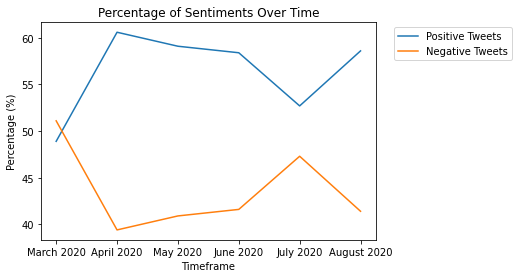

In [84]:
plt.plot(timeframe, num_positive_twts, label = "Positive Tweets")
plt.plot(timeframe, num_negative_twts, label = "Negative Tweets")
plt.legend()
plt.legend(bbox_to_anchor=(1.04, 1), loc = "upper left")
plt.title("Percentage of Sentiments Over Time")
plt.ylabel("Percentage (%)")
plt.xlabel("Timeframe")
plt.show()